In [26]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import shrimpy
import psycopg2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [27]:
class DatabaseClient:
    """
    Functionality for inserting and reading from the database
    """

    def __init__(self):
        # Connect to db
        self.con = psycopg2.connect(
            host='localhost',
            database='postgres',
            user='postgres',
            password='postgres'
        )
        self.article_table = pd.DataFrame()

    def read_db(self):
        cur = self.con.cursor()

        cur.execute("SELECT timestamp, comp_sentiment, sma, ema FROM sent_values WHERE timestamp > '2021-01-26 15:00:00'::timestamp;")

        rows = cur.fetchall()

        self.article_table = pd.DataFrame(data=rows, columns=['timestamp','compound','sma','ema'])


        return self.article_table

In [28]:
database_client = DatabaseClient()
df = database_client.read_db()
df.index = df.timestamp

In [29]:
def get_latest_prices(trading_symbol):
    public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
    secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'
    
    client = shrimpy.ShrimpyApiClient(public_key, secret_key)
        
    # get the candles for historical values
    candles = client.get_candles(
        'binance',  # exchange
        trading_symbol,      # base_trading_symbol
        'USDT',      # quote_trading_symbol
        '1h'       # interval
    )
        
    # Set the dataframe between these two dates
    tomorrows_date = (datetime.today() - timedelta(hours=61)).strftime("%Y-%m-%d %H:00")
    starting_date = '2021-01-25 16:00:00'

    # Put pulled cryptocurrency values into a dataframe and set dates
    prices_df = pd.DataFrame(candles)
    prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

    latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
    latest_prices['close'] = latest_prices['close'].astype('float64')

    return latest_prices

data = get_latest_prices('BTC')
data.index = data.time

<ipython-input-29-5595f8aaaa01>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_prices['close'] = latest_prices['close'].astype('float64')


# Data Preprocessing

In [30]:
dataset_train = data.join(df, lsuffix=data.index, rsuffix=df.index)
dataset_train = dataset_train.drop(columns=['open', 'high', 'low', 'volume', 'quoteVolume', 'btcVolume', 'usdVolume','time','timestamp','compound'])
dataset_train = dataset_train.dropna()

In [31]:
#split into train and validation
train = dataset_train[:800]
valid = dataset_train[800:]

x_train = train.drop('close', axis=1)
y_train = train['close']
x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [32]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

5679.764244853999

<ipython-input-33-7b8c2cadbe8a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
<ipython-input-33-7b8c2cadbe8a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


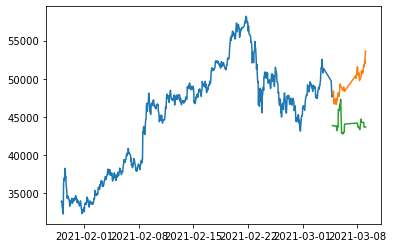

In [33]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = dataset_train[800:].index
train.index = dataset_train[:800].index

plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

# K Nearest Neighbour

In [34]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [35]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [36]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

6433.326100254436

<ipython-input-37-6c65347ebfa1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
<ipython-input-37-6c65347ebfa1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


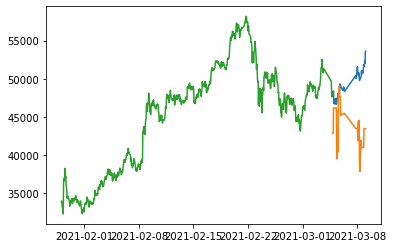

In [37]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['close', 'Predictions']])
plt.plot(train['close'])

# LSTM

In [38]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = dataset_train.index[i]
    new_data['Close'][i] = dataset_train['close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:800,:]
valid = dataset[800:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

740/740 - 10s - loss: 0.0049


In [39]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

nan

<ipython-input-40-4adfbfc2f3ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


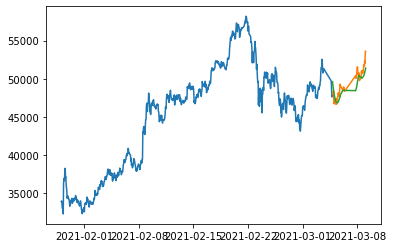

In [40]:
#for plotting
train = new_data[:800]
valid = new_data[800:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [41]:
closing_price

array([[49603.08 ],
       [49193.26 ],
       [48818.016],
       [48520.113],
       [48302.535],
       [48030.656],
       [47746.043],
       [47505.3  ],
       [47321.84 ],
       [47140.246],
       [47014.547],
       [46949.562],
       [46925.703],
       [46871.8  ],
       [46840.227],
       [46823.06 ],
       [46847.3  ],
       [46907.168],
       [47016.293],
       [47152.594],
       [47274.254],
       [47362.027],
       [47456.445],
       [47574.848],
       [47762.055],
       [47964.63 ],
       [48151.785],
       [48297.14 ],
       [48392.742],
       [48450.6  ],
       [48463.23 ],
       [48451.164],
       [48457.977],
       [48465.773],
       [48460.824],
       [48425.184],
       [48537.57 ],
       [48694.523],
       [48875.805],
       [49091.023],
       [49345.85 ],
       [49644.43 ],
       [49949.14 ],
       [50166.305],
       [50305.777],
       [50370.254],
       [50411.418],
       [50392.285],
       [50299.04 ],
       [50180.465],
